<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Machine-Learning-Projects/blob/master/Wine_DecisionTree_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Wine with Decision Tree & Random Forest  </center></h1>

The purpose of this project is to practice the ML techniques of **Decision Tree** & **Random Forest** with the sklearn built-in dataset **wine**, and compare the similarities and differences between  **Decision Tree** & **Random Forest**.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 24px">
    <ol>
        <li><a href="#Part One">Part One: Decision Tree from sklearn</a></li>
      <li><a href="#Part Two">Part Two: Random Forest from sklearn</a></li>
      <li><a href="#Part Three">Part Three: Comparson of Decision Tree & Random Forest</a></li>
    </ol>
</div>
<br>
<hr>

## Import libraries

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_wine

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Part One: Decision Tree

## 1. upload the wine dataset

In [0]:
wine = load_wine()

In [0]:
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

In [94]:
wine_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis = 1)
wine_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,0
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## 2. Split the data into training, testing datasets

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)  # choose 30% of the data as validation dataset

## 3. Create and train the Decision Tree model

In [96]:
# create the model
clf = DecisionTreeClassifier(random_state = 30)
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
score

0.9074074074074074

By default, the performance of the Decision Tree model is 90%.

## 4. Decision Tree Visualization

In [0]:
#!pip install graphviz

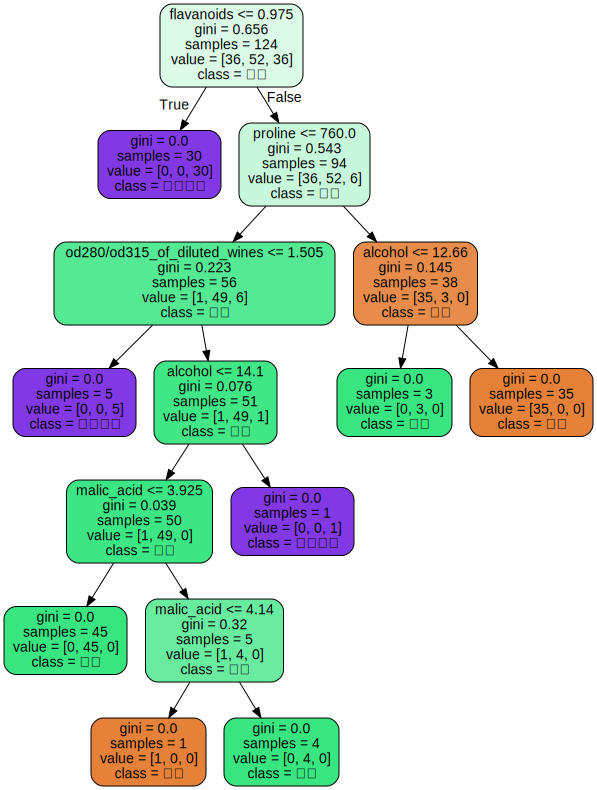

In [98]:
#feature_name = ["酒精", "苹果酸", "灰", "灰的碱性", "镁", "总酚", "类黄酮", "非黄烷类酚类", "花青素", "颜色强度", "色调", "od280/od315稀释葡萄酒", "脯氨酸"]
import graphviz

dot_data = export_graphviz(clf
                           ,feature_names = feature_names
                          ,class_names = ["琴酒", "雪莉", "贝尔摩德"] # target_names
                          ,filled = True
                          ,rounded = True
                          )
graph = graphviz.Source(dot_data)
graph

From the tree graph above, only three features are used to determine the tree. 

In [99]:
feature_importance = [*zip(feature_names, clf.feature_importances_)]
sorted_feature_importance = sorted(feature_importance, key = lambda x: x[1], reverse = True)
sorted_feature_importance

[('proline', 0.40685320507448963),
 ('flavanoids', 0.37183383991894625),
 ('od280/od315_of_diluted_wines', 0.1055713952247566),
 ('alcohol', 0.09163044867069634),
 ('malic_acid', 0.024111111111111114),
 ('ash', 0.0),
 ('alcalinity_of_ash', 0.0),
 ('magnesium', 0.0),
 ('total_phenols', 0.0),
 ('nonflavanoid_phenols', 0.0),
 ('proanthocyanins', 0.0),
 ('color_intensity', 0.0),
 ('hue', 0.0)]

## 5. Decision Tree model fine tune (parameters adjusting)

### Main parameters:
>Parameters | Explanation
>--- | --- 
>**Criterion** | entropy (more sensitive to impurity), gini(default)
>**random_state** | to make the random all the same each time 
>**splitter _ 1:** | best (default) - the model will select the best features based on features importance
>**splitter _ 2:**| random - the model will random select sqrt of features
>**max_depth** | to avoid overfitting
>**min_samples_leaf** & **min_samples_split** | numerical missing value as one class
>**max_features** | categorical 
>**min_impurity_split** | if the info gain < the value, the split will not happen 


## 6. Prune the tree by seting the criterion, max_depth, min_samples_leaf, min_samples_split, etc.

### 6.1 Change criterion from default "gini" to "entropy"

In [100]:
clf = DecisionTreeClassifier(criterion = "entropy", random_state = 30)
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
score

0.9444444444444444

The decision tree performance increases when criterion is changed to "entropy". 

Thus, the **first** parameter is: **criterion = "entropy"**

### 6.2 Change splitter from default "best" to "random"

In [101]:
clf = DecisionTreeClassifier(criterion = "entropy",
                             splitter = "random"
                             ,random_state = 30)
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
score

0.9629629629629629

The decision tree performance increases when splitter is changed to "random". 

Thus, the **second** parameter is: **splitter = "random"**

### 6.3 fine tune parameter: max_depth

Best performance: 0.9814814814814815
max_depth = 3


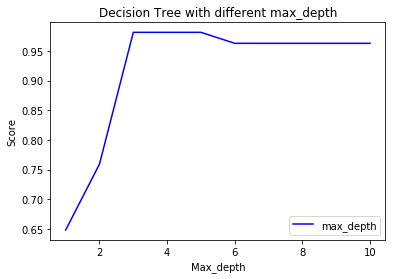

In [102]:
scores = []
for i in range(1, 11):
  clf = DecisionTreeClassifier(criterion = "entropy"
                            ,splitter = "random"
                            ,random_state = 30
                            ,max_depth = i
                              )
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  scores.append(score)

print("Best performance: {}".format(max(scores)))
print("max_depth = {}".format(scores.index(max(scores)) + 1))
plt.plot(range(1, 11), scores, color = "b", label = "max_depth")
plt.title("Decision Tree with different max_depth")
plt.xlabel('Max_depth')
plt.ylabel('Score')
plt.legend()
plt.show()

The decision tree performance increases when splitter is changed to "random". 

Thus, the **third** parameter is: **max_depth = "3"**

### 6.4 fine tune parameter: min_samples_leaf

Best performance: 0.9814814814814815
Min_samples_leaf: 1


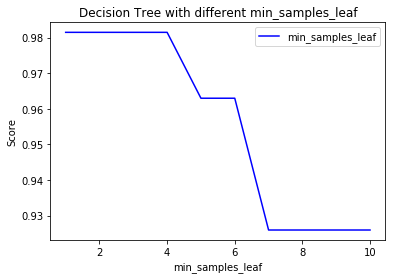

In [103]:
scores = []
for i in range(1, 11):
  clf = DecisionTreeClassifier(criterion = "entropy"
                            ,splitter = "random"
                            ,random_state = 30
                            ,max_depth = 3
                            ,min_samples_leaf = i
                              )
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  scores.append(score)
print("Best performance: {}".format(max(scores)))
print("Min_samples_leaf: {}".format(scores.index(max(scores)) + 1))
plt.plot(range(1, 11), scores, color = "b", label = "min_samples_leaf")
plt.title("Decision Tree with different min_samples_leaf")
plt.xlabel('min_samples_leaf')
plt.ylabel('Score')
plt.legend()
plt.show()

The performance of the model doesnn't change, thus, the default value of min_samples_leaf is the best after the previous parameters determined.

### 6.5 fine tune parameter: min_samples_split

Best performance: 0.9814814814814815
Min_samples_split: 2


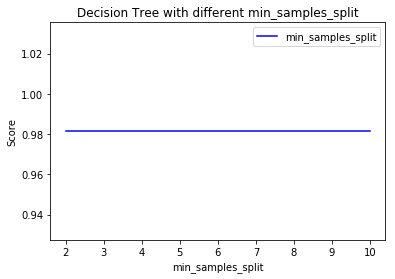

In [104]:
# the minimum value of min_samples_split = 2
scores = []
for i in range(2, 11):
  clf = DecisionTreeClassifier(criterion = "entropy"
                            ,splitter = "random"
                            ,random_state = 30
                            ,max_depth = 3
                            #,min_samples_leaf = i
                            ,min_samples_split = i
                              )
  clf.fit(x_train, y_train)
  score = clf.score(x_test, y_test)
  scores.append(score)
print("Best performance: {}".format(max(scores)))
print("Min_samples_split: {}".format(scores.index(max(scores)) + 2))
plt.plot(range(2, 11), scores, color = "b", label = "min_samples_split")
plt.title("Decision Tree with different min_samples_split")
plt.xlabel('min_samples_split')
plt.ylabel('Score')
plt.legend()
plt.show()

The performance of the model doesnn't change, thus, the default value of min_samples_leaf is the best after the previous parameters determined.

**The best performance model: 98.14%**
- criterion = "entropy"
- splitter = "random"
- max_depth = 3


**The default prameters are the best:**
- min_samples_leaf = 1
- min_samples_split = 2

In [105]:
clf = DecisionTreeClassifier(criterion = "entropy"
                            ,splitter = "random"
                            ,random_state = 30
                            ,max_depth = 3
                            )
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
score

0.9814814814814815

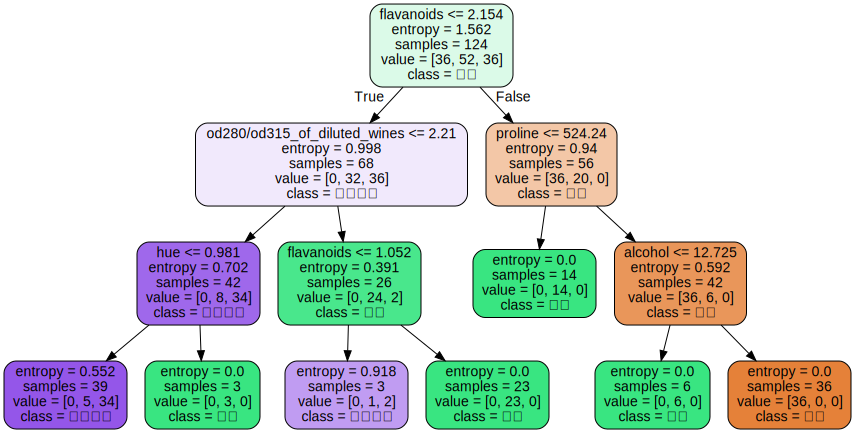

In [106]:
dot_data = export_graphviz(clf
                           ,feature_names = feature_names
                          ,class_names = ["琴酒", "雪莉", "贝尔摩德"] # target_names
                          ,filled = True
                          ,rounded = True
                          )
graph = graphviz.Source(dot_data)
graph

# Part Two: RandomForest

## 1. Create and train the RandomForest model

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 30)  # choose 30% of the data as validation dataset

In [112]:
rfc = RandomForestClassifier(random_state = 30)
rfc.fit(x_train, y_train)
result = rfc.score(x_test, y_test)
result

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9444444444444444

## 2. Random model fine tune (parameters adjusting)

The main parameters are similar to Decision Tree, 

another important parameter for Random Forest is n_estimators: the number of decision trees. 

### Importance of the parameters:
>Parameters | Explanation | importance
>--- | --- | ---
>**n_estimators** | increase n_estimators, doesn't impact DT complexity | ****
>**max_depth** | to avoid overfitting | ***
>**min_samples_leaf** & **min_samples_split** | numerical missing value as one class | **
>**max_features** | the only parameter could either increase or decrease the model complexity, auto = sqrt (default), decrease max_features, --> simple model, increase max_features, --> complex model | *  
>**Criterion** | entropy (more sensitive to impurity), gini(default) | depend on data

## 3. Prune the random forest model by seting the n_estimators, max_depth, min_samples_leaf, min_samples_split, etc.

### 3.1 n_estimators learning curve

Best performance: 0.9888888888888889
The value of n_estimators with the best performance: 14


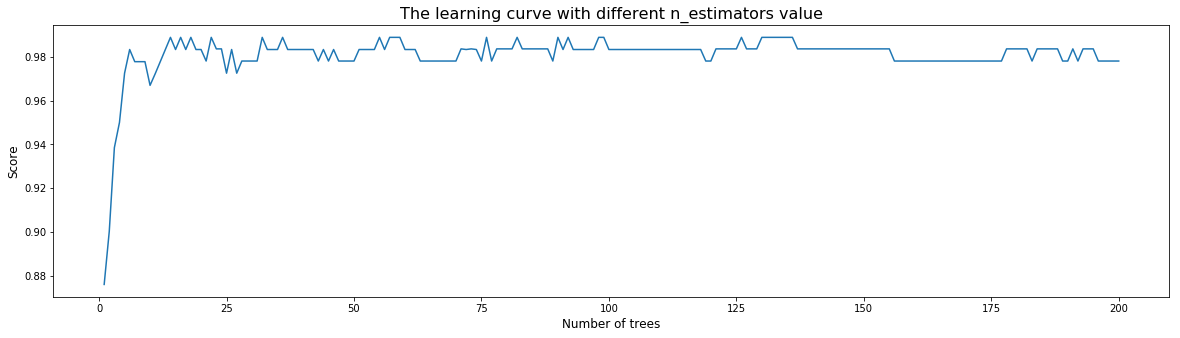

In [20]:
# time warning!!! about 10 minutes
scores = []
for i in range(200):
  rfc = RandomForestClassifier(n_estimators = i + 1, n_jobs = -1, random_state = 30)
  rfc_s = cross_val_score(rfc, wine.data, wine.target, cv = 10).mean()
  scores.append(rfc_s)
  
print("Best performance: {}".format(max(scores)))
print("The value of n_estimators with the best performance: {}".format(scores.index(max(scores)) + 1))
plt.figure(figsize = (20, 5))
plt.plot(range(1, 201), scores)
plt.title("The learning curve with different n_estimators", size = 16)
plt.ylabel("Score", size = 12)
plt.xlabel("Number of trees", size = 12)
plt.show()

# Part Three: Comparson of Decision Tree & Random Forest

## 1. The 10 times cross validation performance of DT & RF 

Decision Tree: 0.9382352941176471
Random Forest: 0.9888888888888889


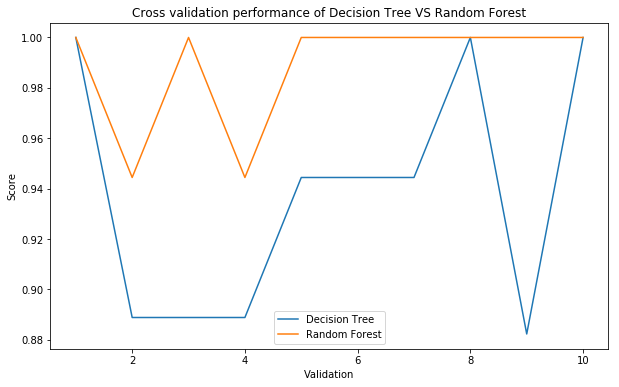

In [86]:
# cross validation of Decision Tree
clf = DecisionTreeClassifier(criterion = "entropy" ,splitter = "random" ,random_state = 30 ,max_depth = 3) # best parameters determined from part one
clf_s = cross_val_score(clf, wine.data, wine.target, cv = 10)

# cross validation of Random Forest
rfc = RandomForestClassifier(n_estimators = 14, random_state = 30)  # best best parameters determined from part two
rfc_s = cross_val_score(rfc, wine.data, wine.target, cv = 10)

print("Decision Tree: {}".format(max(clf_means)))
print("Random Forest: {}".format(max(rfc_means)))

plt.figure(figsize = (10, 6))
plt.title("Cross validation performance of Decision Tree VS Random Forest")
plt.ylabel("Score")
plt.xlabel("Validation")
plt.plot(range(1, 11), clf_s, label = "Decision Tree")
plt.plot(range(1, 11), rfc_s, label = "Random Forest")
plt.legend()
plt.show()

## 2. The mean of 10 times cross validation performance of DT & RF for 15 times

Decision Tree: 0.9382352941176467
Random Forest: 0.9888888888888889


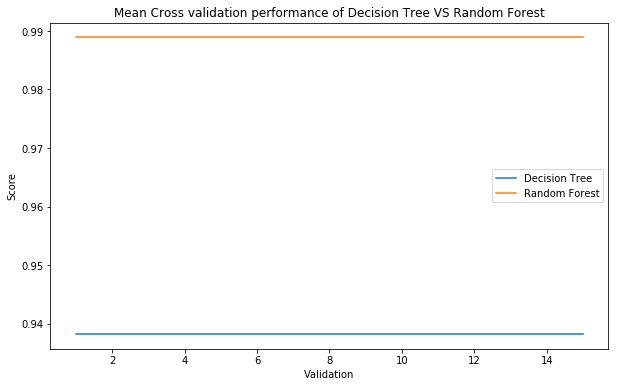

In [87]:
clf_means = []
rfc_means = []

for i in range(15):
  # cross validation of Decision Tree
  clf = DecisionTreeClassifier(criterion = "entropy" ,splitter = "random" ,random_state = 30 ,max_depth = 3) # best parameters determined from part one
  clf_s = cross_val_score(clf, wine.data, wine.target, cv = 10).mean()
  clf_means.append(clf_s)
  
  # cross validation of Random Forest
  rfc = RandomForestClassifier(n_estimators = 14, random_state = 30)  # best best parameters determined from part two
  rfc_s = cross_val_score(rfc, wine.data, wine.target, cv = 10).mean()
  rfc_means.append(rfc_s)
print("Decision Tree: {}".format(np.mean(clf_means)))
print("Random Forest: {}".format(np.mean(rfc_means)))
plt.figure(figsize = (10, 6))
plt.title("Mean Cross validation performance of Decision Tree VS Random Forest")
plt.ylabel("Score")
plt.xlabel("Validation")
plt.plot(range(1, 16), clf_means, label = "Decision Tree")
plt.plot(range(1, 16), rfc_means, label = "Random Forest")
plt.legend()
plt.show()

## The limitation about Decision Tree and Random Forest

- The current strategy of creating trees is greedy. We can only get the local optimal.

It will find the largest information gain right now and split on that feature. We never consider the ramifications of that split futher down the tree. 

Finding a globally optimal tree is an extremely difficult task, and finding a tree using our greedy approach is reasonable substitute.

- Another problem with our trees is that they potentially overfit the data. 

This means that the structure of the tree is too dependent on the training data and doesn't accurately represent the way the data in the real world looks like. In general, larger trees tend to overfit the data more. As the tree gets bigger, it becomes more tuned to the training data and it loses a more generalized understanding of the real world data

One way to solve the overfitting problem is to prune the tree. The goal of pruning is to shrink the size of the tree. There are a few different pruning strategies. 

## Discussion about the parameters
Usually the decision tree model or random forest model are easy to be overfitting. 
The parameters adjusting is usually to decrease the model complexity, to aovid overfitting. 

**The parameters decrease model complexity to avoid overfitting:**

- increase min_samples_leaf (the default value is the smallest)
- increase min_samples_split (the default value is the smallest)
- decrease max_depth (the default value is the largest)

**The only parameter could either increaes or decrease the model complexity:**

- max_features (sqrt by default, could increase or decrease)


**Other parameters:**
- criterion: gini, entropy
- n_estimators: doesn't change each decision, but very import to RF model.

In general, the parameters of DT and RF are similar. 
